In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np

In [42]:

# Download and prepare the original dataset
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset = keras.utils.get_file("flower_photos", origin=url, untar=True)

# Create directories for our two-stage transfer learning
original_dataset = "original_flower_photos"

new_dataset = "new_flower_photos"
os.makedirs(original_dataset, exist_ok=True)
os.makedirs(new_dataset, exist_ok=True)

def copy_directory(src, dst):
    if not os.path.exists(dst):
        shutil.copytree(src, dst)
    else:
        print(f"Directory {dst} already exists. Skipping.")

# Copy 4 classes to the original dataset directory
classes_to_use = ['daisy', 'dandelion', 'roses', 'tulips']
for flower_class in classes_to_use:
    src = os.path.join(dataset, flower_class)
    dst = os.path.join(original_dataset, flower_class)
    copy_directory(src, dst)

# Copy all classes including sunflowers to the new dataset directory
for flower_class in os.listdir(dataset):
    if os.path.isdir(os.path.join(dataset, flower_class)):
        src = os.path.join(dataset, flower_class)
        dst = os.path.join(new_dataset, flower_class)
        copy_directory(src, dst)

Directory original_flower_photos/daisy already exists. Skipping.
Directory original_flower_photos/dandelion already exists. Skipping.
Directory original_flower_photos/roses already exists. Skipping.
Directory original_flower_photos/tulips already exists. Skipping.
Directory new_flower_photos/roses already exists. Skipping.
Directory new_flower_photos/sunflowers already exists. Skipping.
Directory new_flower_photos/daisy already exists. Skipping.
Directory new_flower_photos/dandelion already exists. Skipping.
Directory new_flower_photos/tulips already exists. Skipping.


In [43]:
# Set up image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Generator for the original dataset
original_train_generator = train_datagen.flow_from_directory(
    original_dataset,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

original_validation_generator = train_datagen.flow_from_directory(
    original_dataset,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)



Found 2379 images belonging to 4 classes.
Found 592 images belonging to 4 classes.


In [44]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [45]:
# Create and train the original model
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(4, activation='softmax')  # 4 classes in original dataset
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
# Train the model on the original dataset
history = model.fit(
    original_train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=original_validation_generator,
    validation_steps=50
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 262ms/step - accuracy: 0.6258 - loss: 0.8914 - val_accuracy: 0.8463 - val_loss: 0.4227
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 250ms/step - accuracy: 0.8495 - loss: 0.3993 - val_accuracy: 0.8615 - val_loss: 0.3734
Epoch 3/10


2024-09-22 19:37:37.492244: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 244ms/step - accuracy: 0.8664 - loss: 0.3469 - val_accuracy: 0.8801 - val_loss: 0.3275
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.8840 - loss: 0.2976 - val_accuracy: 0.9037 - val_loss: 0.3066
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 238ms/step - accuracy: 0.8911 - loss: 0.2860 - val_accuracy: 0.8767 - val_loss: 0.3588
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - accuracy: 0.9046 - loss: 0.2743 - val_accuracy: 0.8801 - val_loss: 0.3180
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - accuracy: 0.9149 - loss: 0.2292 - val_accuracy: 0.8750 - val_loss: 0.3239
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - accuracy: 0.9279 - loss: 0.2176 - val_accuracy: 0.8632 - val_loss: 0.3269
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 256ms/step - accuracy: 0.9186 - loss: 0.2255 - val_accuracy: 0.8851 - val_loss: 0.2995
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 264ms/step - accuracy: 0.9190 - loss: 0.2301 - va

In [47]:
# Time for Transfer Learning , let's adapt the model for the new class (sunflowers)
model.layers.pop()  # Remove the last dense layer
for layer in model.layers:
    layer.trainable = False  # Freeze all layers

# Add new layers for transfer learning
model = keras.Sequential([
    model,
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='softmax')  # 5 classes including sunflowers
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [48]:
# Generator for the new dataset (including all 5 classes)
new_train_generator = train_datagen.flow_from_directory(
    new_dataset,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

new_validation_generator = train_datagen.flow_from_directory(
    new_dataset,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [49]:
print("Number of classes in new_train_generator:", len(new_train_generator.class_indices))
print("Number of classes in new_validation_generator:", len(new_validation_generator.class_indices))

Number of classes in new_train_generator: 5
Number of classes in new_validation_generator: 5


In [50]:
print("Number of neurons in the output layer:", model.layers[-1].units)

Number of neurons in the output layer: 5


In [51]:
print("Shape of a batch from new_train_generator:", next(iter(new_train_generator))[0].shape, next(iter(new_train_generator))[1].shape)
print("Shape of a batch from new_validation_generator:", next(iter(new_validation_generator))[0].shape, next(iter(new_validation_generator))[1].shape)

Shape of a batch from new_train_generator: (32, 224, 224, 3) (32, 5)
Shape of a batch from new_validation_generator: (32, 224, 224, 3) (32, 5)


In [52]:
# Recreate the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
class NanCallback(keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print('Batch %d: Invalid loss, terminating training' % batch)
                self.model.stop_training = True

nan_callback = NanCallback()

In [54]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
steps_per_epoch = len(new_train_generator)
validation_steps = len(new_validation_generator)

transfer_history = model.fit(
    new_train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=new_validation_generator,
    validation_steps=validation_steps,
    callbacks=[nan_callback]
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 329ms/step - accuracy: 0.6624 - loss: 0.9081 - val_accuracy: 0.8057 - val_loss: 0.5185
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 350ms/step - accuracy: 0.8597 - loss: 0.3795 - val_accuracy: 0.8331 - val_loss: 0.4870
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 322ms/step - accuracy: 0.8686 - loss: 0.3445 - val_accuracy: 0.8263 - val_loss: 0.4665
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 330ms/step - accuracy: 0.8937 - loss: 0.2764 - val_accuracy: 0.8564 - val_loss: 0.4351
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 324ms/step - accuracy: 0.9069 - loss: 0.2631 - val_accuracy: 0.856

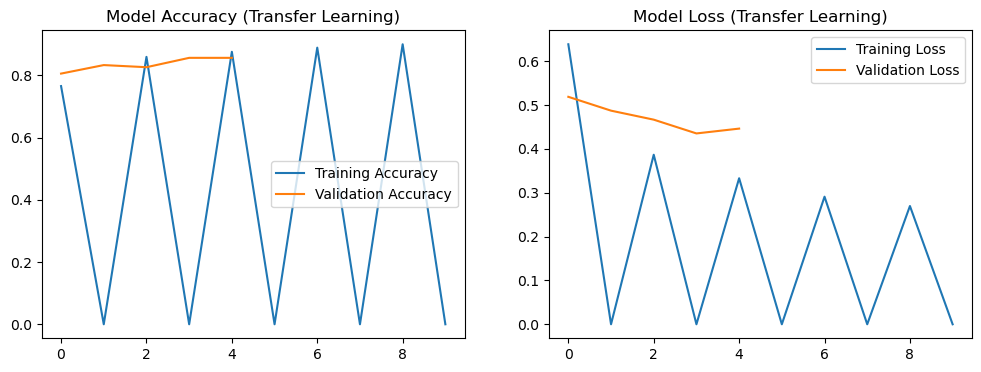

In [56]:


# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(transfer_history.history['accuracy'], label='Training Accuracy')
plt.plot(transfer_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy (Transfer Learning)')

plt.subplot(1, 2, 2)
plt.plot(transfer_history.history['loss'], label='Training Loss')
plt.plot(transfer_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss (Transfer Learning)')
plt.show()



In [57]:
# Function to predict and display an image
def predict_and_display(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    class_names = list(new_train_generator.class_indices.keys())
    predicted_class = class_names[tf.argmax(prediction[0])]
    confidence = tf.reduce_max(prediction[0])

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


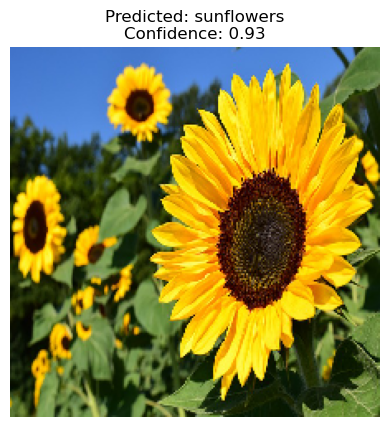

In [58]:
# Example usage
predict_and_display('./data/sunflower.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


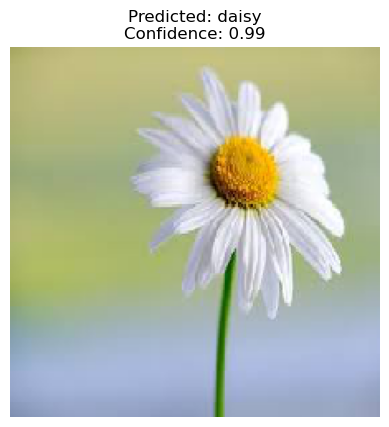

In [59]:
# Example usage
predict_and_display('./data/daisy.jpeg')